In [14]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/46.2 kB ? eta -:--:--
     ---------------------------------------- 46.2/46.2 kB 1.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/377.0 MB ? eta -:--:--
   ---------------------------------------- 1.4/377.0 MB 29.0 MB/s eta 0:00:13
   ---------------------------------------- 3.6/377.0 MB 38.2 MB/s eta 0:00:10
    --------------------------------------- 6.2/377.0 MB 44.4 MB/s eta 0:00:09
    --------------------------------------- 9.3/377.0 MB 49.4 MB/s eta 0:00:08
   - -------------------------------------- 12.0/377.0 MB 54.7 MB/s eta 0:00:07
   - -------------------------------------- 14.7/377.0 MB 59.5 MB/s eta 0:00:07
   - -------------------------------------- 17.4/377.0 MB 59.5 MB/s eta 0:00:07
   -- ------------------------------------- 20.6/377.0 MB 59.5 MB/s eta 0:00:06
   -- ------------------------------------- 23.8/377.0 MB 65.2 

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [6]:
# Importar librerías de manejo de datos
import pandas as pd
import numpy as np
import os

# Librerías para el manejo y procesamiento de imágenes
from PIL import Image

# Librerías para el manejo de tiempo (medición de performance)
import time

# Importar TensorFlow y Keras para modelos de aprendizaje profundo
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

# Librerías para cálculos de similitud y métricas
from sklearn.metrics.pairwise import cosine_similarity

# Visualización de imagenes para comprobacion de resultados
import matplotlib.pyplot as plt

## Paso 1: Preparación del Dataset

**Objetivo:** Cargar y preparar el dataset para el procesamiento. Esto incluye la carga de metadatos desde `styles.csv` y la preparación de las imágenes para que todas tengan el mismo tamaño y formato de color, adecuados para el modelo de red neuronal.

### Carga de Metadatos
Utilizamos `pandas` para leer el archivo CSV que contiene información esencial sobre cada imagen, como los IDs y otras etiquetas que serán útiles para el procesamiento posterior.



In [7]:
# Cargar metadata
styles = pd.read_csv('fashion-dataset/styles.csv', on_bad_lines='skip')

### Definición de la Función de Carga de Imágenes
Definimos una función que se encargue de cargar y procesar cada imagen, convirtiéndola a formato RGB y redimensionándola a un tamaño estándar compatible con modelos de redes neuronales preentrenadas


In [10]:
def load_image(image_path):
    with Image.open(image_path) as img:
        img = img.convert('RGB')
        img = img.resize((224, 224))
    return np.array(img)

# Preparación de las rutas de imágenes
images_dir = 'fashion-dataset/images/'
image_files = [os.path.join(images_dir, f'{row.id}.jpg') for index, row in styles.iterrows() if os.path.isfile(os.path.join(images_dir, f'{row.id}.jpg'))]

### Estimación y Procesamiento de Todas las Imágenes
Estimamos el tiempo que tomará procesar todas las imágenes basándonos en una muestra pequeña y luego procesamos todas las imágenes para verificar la precisión de nuestra estimación


In [12]:
# Estimar el tiempo de procesamiento
sample_size = 10
start_time = time.time()

# Procesar una muestra de imágenes para estimar el tiempo
sample_images = np.array([load_image(image_files[i]) for i in range(min(sample_size, len(image_files)))])
sample_end_time = time.time()

# Calcular el tiempo medio por imagen
average_time_per_image = (sample_end_time - start_time) / len(sample_images)
estimated_total_time = average_time_per_image * len(image_files)
print(f"Tiempo estimado para procesar {len(image_files)} imágenes: {estimated_total_time:.2f} segundos")

# Procesar todas las imágenes y medir el tiempo real
start_time_all_images = time.time()
images = np.array([load_image(img) for img in image_files])
end_time_all_images = time.time()
print(f"Tiempo real para procesar {len(image_files)} imágenes: {end_time_all_images - start_time_all_images:.2f} segundos")

Tiempo estimado para procesar 44419 imágenes: 2762.60 segundos
Tiempo real para procesar 44419 imágenes: 2093.30 segundos


In [7]:
# Estimar el tiempo de procesamiento
sample_size = 10  # Número de imágenes para el cálculo del tiempo de muestra
start_time = time.time()

# Procesar una muestra de imágenes para estimar el tiempo
sample_images = np.array([load_image(image_files[i]) for i in range(min(sample_size, len(image_files)))])
sample_end_time = time.time()

# Calcular el tiempo medio por imagen
average_time_per_image = (sample_end_time - start_time) / len(sample_images)

# Estimar el tiempo total basado en todas las imágenes
estimated_total_time = average_time_per_image * len(image_files)

print(f"Tiempo estimado para procesar {len(image_files)} imágenes: {estimated_total_time:.2f} segundos")


Tiempo estimado para procesar 44419 imágenes: 1929.28 segundos


## Paso 2: Extracción de Características

**Objetivo:** Utilizar una red preentrenada para extraer características significativas de las imágenes procesadas. Estas características serán utilizadas para comparar imágenes y encontrar similitudes.

### Cargar y Preparar Modelo Preentrenado
Usamos VGG16 como modelo de base debido a su efectividad en capturar la esencia visual de las imáges.



In [14]:
# Cargar VGG16 preentrenada
base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.output)

# Preprocesar imágenes para el modelo
images_preprocessed = preprocess_input(images)

# Extraer características
features = model.predict(images_preprocessed)
features_flattened = features.reshape(features.shape[0], -1)

# Guardar el modelo y las características extraídas para uso futuro
model.save('vgg16_feature_extractor.keras')
np.save('extracted_features.npy', features_flattened)

1389/1389 ━━━━━━━━━━━━━━━━━━━━ 2634s 2s/step


## Paso 3: Construcción del Sistema de Búsqueda de Imágenes

**Objetivo:** Implementar un sistema para buscar imágenes similares usando las características extraídas. La similitud entre las imágenes se determinará mediante el cálculo de la distancia entre sus vectores de características.

### Cargar Modelo y Características
Cargamos el modelo y las características guardadas para realizar búsquedas eficientes sin necesidad de re-procesamito.



In [47]:
# Cargar el modelo y las características
model = load_model('vgg16_feature_extractor.keras')
features_flattened = np.load('extracted_features.npy')

# Calcular similitudes del coseno entre todas las imágenes
similarities = cosine_similarity(features_flattened)

def get_similar_images(index, num_results=10):
    similar_indices = np.argsort(-similarities[index])[:num_results]
    return similar_indices


# Ejemplo de uso: buscar imágenes similares a la imagen en el índice 0
index_of_query_image = 0
similar_images = get_similar_images(index_of_query_image)
print(similar_images)

[    0 32845  3899 35075 35592  9567 38293 31272  7055 27726]


## Evaluación y Mejoras

**Objetivo:** Evaluar la precisión del sistema de búsqueda de imágenes y hacer ajustes según sea necesario. Esto puede implicar ajustar parámetros del modelo, la técnica de similitud utilizada, o el método de extracción de características.## Visualización de Imágenes Similares

### Objetivo
El objetivo de esta sección es visualizar la imagen de consulta junto con las imágenes que el sistema ha identificado como más similares. Esto nos permite realizar una verificación visual rápida de la efectividad de nuestro sistema de búsqueda de imágenes.

### Función de Visualización
La función `show_images` se define para tomar una lista de rutas de imágenes y mostrarlas en una fila en el notebook. Cada imagen se muestra con un título correspondiente que puede ser personalizado. Además, se puede especificar un título principal para todo el conjunto de imágenes.

### Proceso de Visualización
1. **Seleccionar la Imagen de Consulta:** Se selecciona una imagen de consulta de nuestro dataset, cuyo índice es especificado manualmente en la variable `index_of_query_image`.
2. **Encontrar Imágenes Similares:** Utilizando la función `get_similar_images`, encontramos las top 5 imágenes más similares a nuestra imagen de consulta.
3. **Preparar Datos para Visualización:** Preparamos las rutas de las imágenes y los títulos correspondientes para la visualización.
4. **Visualizar:** Llamamos a `show_images` con las rutas y títulos preparados para mostrar las imágenes en el notebook.

### Resultados
La imagen de consulta y sus imágenes similares se muestran abajo. Esto nos permite evaluar visualmente si las imágenes recuperadas son de hecho visualmente similares a la imagen de consulta, ayudando a verificar y mejorar nuestro sistema de búsqueda de imágenes.
dos.


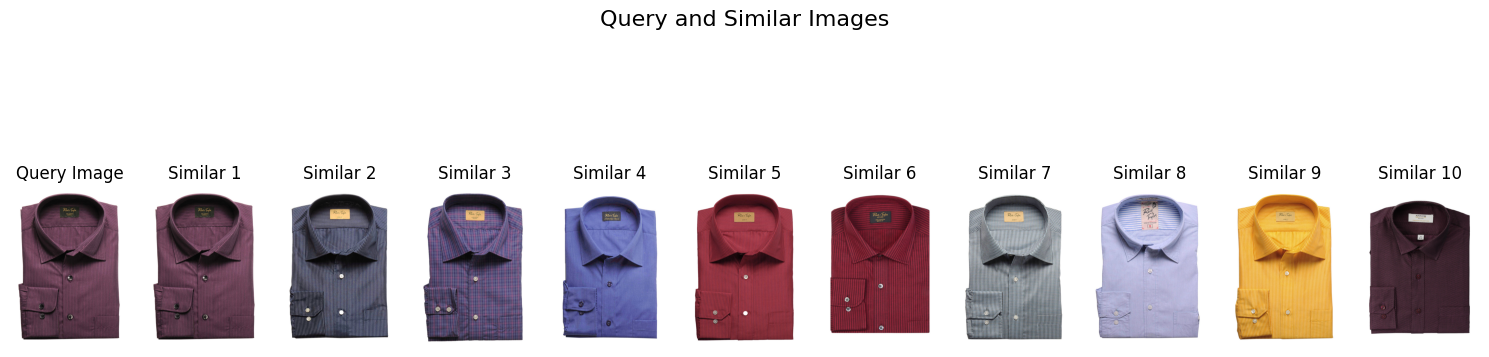

In [65]:
import matplotlib.pyplot as plt
from PIL import Image

def show_images(image_paths, titles=None, main_title=None):
    num_images = len(image_paths)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    if main_title:
        fig.suptitle(main_title, fontsize=16)
    if num_images == 1:
        axes = [axes]
    for ax, img_path, title in zip(axes, image_paths, titles or ['']*num_images):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

index_of_query_image = 15  # Asegúrate de que esto es un índice entero
similar_images_indices = get_similar_images(index_of_query_image, num_results=10)  # Esto también debe ser una lista de índices enteros

image_paths = [image_files[index_of_query_image]] + [image_files[i] for i in similar_images_indices]
titles = ['Query Image'] + ['Similar {}'.format(i+1) for i in range(len(similar_images_indices))]

show_images(image_paths, titles=titles, main_title="Query and Similar Images")